# Handwritten Digit Recognition using Convolutional Neural Networks in Python with Keras
http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/

A popular demonstration of the capability of deep learning techniques is object recognition in image data.

The “hello world” of object recognition for machine learning and deep learning is the MNIST dataset for handwritten digit recognition.

In this post you will discover how to develop a deep learning model to achieve near state of the art performance on the MNIST handwritten digit recognition task in Python using the Keras deep learning library.

After completing this tutorial, you will know:

How to load the MNIST dataset in Keras.
How to develop and evaluate a baseline neural network model for the MNIST problem.
How to implement and evaluate a simple Convolutional Neural Network for MNIST.
How to implement a close to state-of-the-art deep learning model for MNIST.
Let’s get started.

## Description of the MNIST Handwritten Digit Recognition Problem

The [MNIST](http://yann.lecun.com/exdb/mnist/) problem is a dataset developed by Yann LeCun, Corinna Cortes and Christopher Burges for evaluating machine learning models on the handwritten digit classification problem.

The dataset was constructed from a number of scanned document dataset available from the [National Institute of Standards and Technology](http://www.nist.gov/) (NIST). This is where the name for the dataset comes from, as the Modified NIST or MNIST dataset.

Images of digits were taken from a variety of scanned documents, normalized in size and centered. This makes it an excellent dataset for evaluating models, allowing the developer to focus on the machine learning with very little data cleaning or preparation required.

Each image is a 28 by 28 pixel square (784 pixels total). A standard spit of the dataset is used to evaluate and compare models, where 60,000 images are used to train a model and a separate set of 10,000 images are used to test it.

It is a digit recognition task. As such there are 10 digits (0 to 9) or 10 classes to predict. Results are reported using prediction error, which is nothing more than the inverted classification accuracy.

Excellent results achieve a prediction error of less than 1%. State-of-the-art prediction error of approximately 0.2% can be achieved with large Convolutional Neural Networks. There is a listing of the state-of-the-art results and links to the relevant papers on the MNIST and other datasets on [Rodrigo Benenson’s webpage](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354).

## Loading the MNIST dataset in Keras

The Keras deep learning library provides a convenience method for loading the MNIST dataset.

The dataset is downloaded automatically the first time this function is called and is stored in your home directory in ~/.keras/datasets/mnist.pkl.gz as a 15MB file.

This is very handy for developing and testing deep learning models.

To demonstrate how easy it is to load the MNIST dataset, we will first write a little script to download and visualize the first 4 images in the training dataset.

Using Theano backend.


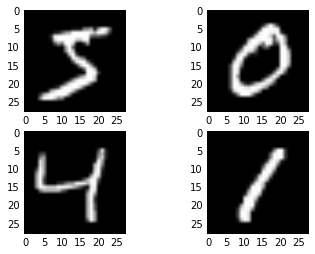

In [1]:
# Plot ad hoc mnist instances
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))

# show the plot
plt.show();

## Baseline Model with Multi-Layer Perceptrons

Do we really need a complex model like a convolutional neural network to get the best results with MNIST?

You can get very good results using a very simple neural network model with a single hidden layer. In this section we will create a simple multi-layer perceptron model that achieves an error rate of 1.74%. We will use this as a baseline for comparing more complex convolutional neural network models.

Let’s start off by importing the classes and functions we will need.

In [2]:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

It is always a good idea to initialize the random number generator to a constant to ensure that the results of your script are reproducible.

In [3]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Now we can load the MNIST dataset using the Keras helper function.

In [4]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

The training dataset is structured as a 3-dimensional array of instance, image width and image height. For a multi-layer perceptron model we must reduce the images down into a vector of pixels. In this case the 28×28 sized images will be 784 pixel input values.

We can do this transform easily using the [reshape() function](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.reshape.html) on the NumPy array. We can also reduce our memory requirements by forcing the precision of the pixel values to be 32 bit, the default precision used by Keras anyway.

In [5]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

The pixel values are gray scale between 0 and 255. It is almost always a good idea to perform some scaling of input values when using neural network models. Because the scale is well known and well behaved, we can very quickly normalize the pixel values to the range 0 and 1 by dividing each value by the maximum of 255.

In [6]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

Finally, the output variable is an integer from 0 to 9. This is a multi-class classification problem. As such, it is good practice to use a one hot encoding of the class values, transforming the vector of class integers into a binary matrix.

We can easily do this using the built-in np_utils.to_categorical() helper function in Keras.

In [7]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

We are now ready to create our simple neural network model. We will define our model in a function. This is handy if you want to extend the example later and try and get a better score.

In [10]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, init='normal', activation='relu'))
    model.add(Dense(num_classes, init='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

The model is a simple neural network with one hidden layer with the same number of neurons as there are inputs (784). A rectifier activation function is used for the neurons in the hidden layer.

A softmax activation function is used on the output layer to turn the outputs into probability-like values and allow one class of the 10 to be selected as the model’s output prediction. Logarithmic loss is used as the loss function (called categorical_crossentropy in Keras) and the efficient ADAM gradient descent algorithm is used to learn the weights.

We can now fit and evaluate the model. The model is fit over 10 epochs with updates every 200 images. The test data is used as the validation dataset, allowing you to see the skill of the model as it trains. A verbose value of 2 is used to reduce the output to one line for each training epoch.

Finally, the test dataset is used to evaluate the model and a classification error rate is printed.

In [11]:
# build the model
model = baseline_model()

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
6s - loss: 0.2791 - acc: 0.9203 - val_loss: 0.1421 - val_acc: 0.9578
Epoch 2/10
6s - loss: 0.1123 - acc: 0.9679 - val_loss: 0.0998 - val_acc: 0.9696
Epoch 3/10
6s - loss: 0.0724 - acc: 0.9789 - val_loss: 0.0786 - val_acc: 0.9746
Epoch 4/10
6s - loss: 0.0510 - acc: 0.9855 - val_loss: 0.0788 - val_acc: 0.9761
Epoch 5/10
6s - loss: 0.0366 - acc: 0.9898 - val_loss: 0.0638 - val_acc: 0.9795
Epoch 6/10
6s - loss: 0.0265 - acc: 0.9929 - val_loss: 0.0643 - val_acc: 0.9798
Epoch 7/10
6s - loss: 0.0185 - acc: 0.9958 - val_loss: 0.0609 - val_acc: 0.9807
Epoch 8/10
6s - loss: 0.0147 - acc: 0.9969 - val_loss: 0.0620 - val_acc: 0.9812
Epoch 9/10
6s - loss: 0.0106 - acc: 0.9981 - val_loss: 0.0599 - val_acc: 0.9816
Epoch 10/10
6s - loss: 0.0073 - acc: 0.9987 - val_loss: 0.0594 - val_acc: 0.9819
Baseline Error: 1.81%


Running the example might take a few minutes when run on a CPU. You should see the output above. This very simple network defined in very few lines of code achieves a respectable error rate of 1.74%.

## Simple Convolutional Neural Network for MNIST

Now that we have seen how to load the MNIST dataset and train a simple multi-layer perceptron model on it, it is time to develop a more sophisticated convolutional neural network or CNN model.

Keras does provide a lot of capability for [creating convolutional neural networks](http://keras.io/layers/convolutional/).

In this section we will create a simple CNN for MNIST that demonstrates how to use all of the aspects of a modern CNN implementation, including Convolutional layers, Pooling layers and Dropout layers.

The first step is to import the classes and functions needed.

In [12]:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

Again, we always initialize the random number generator to a constant seed value for reproducibility of results.

In [13]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Next we need to load the MNIST dataset and reshape it so that it is suitable for use training a CNN. In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [pixels][width][height].

In the case of RGB, the first dimension pixels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In the case of MNIST where the pixel values are gray scale, the pixel dimension is set to 1.

In [14]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

As before, it is a good idea to normalize the pixel values to the range 0 and 1 and one hot encode the output variables.

In [15]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

Next we define our neural network model.

Convolutional neural networks are more complex than standard multi-layer perceptrons, so we will start by using a simple structure to begin with that uses all of the elements for state of the art results. Below summarizes the network architecture.

1. The first hidden layer is a convolutional layer called a Convolution2D. The layer has 32 feature maps, which with the size of 5×5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above [pixels][width][height].
2. Next we define a pooling layer that takes the max called MaxPooling2D. It is configured with a pool size of 2×2.
3. The next layer is a regularization layer using dropout called Dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
4. Next is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
5. Next a fully connected layer with 128 neurons and rectifier activation function.
6. Finally, the output layer has 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.

As before, the model is trained using logarithmic loss and the ADAM gradient descent algorithm.

In [16]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

We evaluate the model the same way as before with the multi-layer perceptron. The CNN is fit over 10 epochs with a batch size of 200.

In [17]:
# build the model
model = baseline_model()

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
95s - loss: 0.2412 - acc: 0.9318 - val_loss: 0.0752 - val_acc: 0.9766
Epoch 2/10
95s - loss: 0.0727 - acc: 0.9780 - val_loss: 0.0531 - val_acc: 0.9829
Epoch 3/10
97s - loss: 0.0498 - acc: 0.9850 - val_loss: 0.0390 - val_acc: 0.9857
Epoch 4/10
97s - loss: 0.0417 - acc: 0.9867 - val_loss: 0.0420 - val_acc: 0.9859
Epoch 5/10
94s - loss: 0.0326 - acc: 0.9897 - val_loss: 0.0394 - val_acc: 0.9860
Epoch 6/10
574s - loss: 0.0287 - acc: 0.9910 - val_loss: 0.0423 - val_acc: 0.9857
Epoch 7/10
98s - loss: 0.0224 - acc: 0.9929 - val_loss: 0.0323 - val_acc: 0.9892
Epoch 8/10
96s - loss: 0.0202 - acc: 0.9936 - val_loss: 0.0370 - val_acc: 0.9885
Epoch 9/10
96s - loss: 0.0160 - acc: 0.9951 - val_loss: 0.0321 - val_acc: 0.9888
Epoch 10/10
95s - loss: 0.0143 - acc: 0.9953 - val_loss: 0.0315 - val_acc: 0.9891
Baseline Error: 1.09%


Running the example, the accuracy on the training and validation test is printed each epoch and at the end of the classification error rate is printed.

Epochs may take 60 to 90 seconds to run on the CPU, or about 15 minutes in total depending on your hardware. You can see that the network achieves an error rate of 1.10, which is better than our simple multi-layer perceptron model above.

## Larger Convolutional Neural Network for MNIST

Now that we have seen how to create a simple CNN, let’s take a look at a model capable of close to state of the art results.

We import classes and function then load and prepare the data the same as in the previous CNN example.

In [18]:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

This time we define a large CNN architecture with additional convolutional, max pooling layers and fully connected layers. The network topology can be summarized as follows.

1. Convolutional layer with 30 feature maps of size 5×5.
2. Pooling layer taking the max over 2*2 patches.
3. Convolutional layer with 15 feature maps of size 3×3.
4. Pooling layer taking the max over 2*2 patches.
5. Dropout layer with a probability of 20%.
6. Flatten layer.
7. Fully connected layer with 128 neurons and rectifier activation.
8. Fully connected layer with 50 neurons and rectifier activation.
9. Output layer.

In [19]:
def larger_model():
    # create model
    model = Sequential()
    model.add(Convolution2D(30, 5, 5, border_mode='valid', input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(15, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Like the previous two experiments, the model is fit over 10 epochs with a batch size of 200.

In [20]:
# build the model
model = larger_model()

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10


KeyboardInterrupt: 

Running the example prints accuracy on the training and validation datasets each epoch and a final classification error rate.

The model takes about 100 seconds to run per epoch. This slightly larger model achieves the respectable classification error rate of 0.89%.

This is not an optimized network topology. Nor is a reproduction of a network topology from a recent paper. There is a lot of opportunity for you to tune and improve upon this model.

What is the best error rate score you can achieve?

Post your configuration and best score in the comments.

## Resources on MNIST

The MNIST dataset is very well studied. Below are some additional resources you might like to look into.

- [The Official MNIST dataset webpage](http://yann.lecun.com/exdb/mnist/).
- [Rodrigo Benenson’s webpage that lists state of the art results](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354).
- [Kaggle competition that uses this dataset](https://www.kaggle.com/c/digit-recognizer) (check the scripts and forum sections for sample code)
- [Read-only model trained on MNIST that you can test in your browser](http://myselph.de/neuralNet.html) (very cool)